In [90]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
from matplotlib.pyplot import figure
import hickle as hkl
import time
import datetime

from matplotlib.animation import FuncAnimation
import psutil
import collections
import os
from IPython.display import clear_output

import copy


mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# function
## 2d面积公式

In [2]:
# 计算2d三角形面积公式
def heron(a,b,c):  
    s = (a + b + c) / 2   
    area = (s*(s-a) * (s-b)*(s-c)) ** 0.5        
    return area

def distance2d(x1,y1,z1,x2,y2,z2):    
    a=(x1-x2)**2+(y1-y2)**2
    d= a ** 0.5  
    return d  

def areatriangle2d(x1,y1,z1,x2,y2,z2,x3,y3,z3):  
    a=distance2d(x1,y1,z1,x2,y2,z2)  
    b=distance2d(x2,y2,z2,x3,y3,z3)  
    c=distance2d(x3,y3,z3,x1,y1,z1)  
    A = heron(a,b,c)  
    print("area of triangle is %r " %A)
    
def areatriangle2d_By_Points(p1,p2,p3,w,h):  
    x1 = p1.x*w
    y1 = p1.y*h
    z1 = p1.z*w
    
    x2 = p2.x*w
    y2 = p2.y*h
    z2 = p2.z*w
    
    x3 = p3.x*w
    y3 = p3.y*h
    z3 = p3.z*w
    
#     z1 = 0
#     z2 = 0
#     z3 = 0
    a=distance2d(x1,y1,z1,x2,y2,z2)  
    b=distance2d(x2,y2,z2,x3,y3,z3)  
    c=distance2d(x3,y3,z3,x1,y1,z1)  
    A = heron(a,b,c)
    return A


def areatriangle2d_sum(hand_landmarks,w,h): 
    extract_point = [4,8,12,16,20,0]
    p = []
    for i in extract_point:
        p.append(hand_landmarks.landmark[i])
    a1 = areatriangle2d_By_Points(p[0],p[1],p[2],w,h)
    a2 = areatriangle2d_By_Points(p[0],p[2],p[3],w,h)
    a3 = areatriangle2d_By_Points(p[0],p[3],p[4],w,h)
    a4 = areatriangle2d_By_Points(p[0],p[4],p[5],w,h)
    
    a = a1+a2+a3+a4
    return a


## record data
Without images
+ input: save data file name
+ output: 
    + saved data name
    + saved data


In [3]:
# 按照 时间, index, 存储 坐标和图像信息, 读取并重新画图分析
# test the 2D area stable in the video stream
def hand_area_tracking_recording(filename): 

    now = datetime.datetime.now()
    now_ts = time.time()
    data_s = []
    index_s = []
    time_s = []
    result_s = []
    image_s = []
    image_size = []
    idx = 0

    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_hands = mp.solutions.hands


    hand_area = collections.deque(np.zeros(500))
    hand_z = collections.deque(np.zeros(500))

    hand_z1 = collections.deque(np.zeros(500))
    hand_z2 = collections.deque(np.zeros(500))
    hand_z3 = collections.deque(np.zeros(500))
    hand_z4 = collections.deque(np.zeros(500))

    cap = cv2.VideoCapture(0)
    with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=1,
    #     model_complexity=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as hands:
      while cap.isOpened():
        success, image = cap.read()
        ts = time.time()
        if not success:
          print("Ignoring empty camera frame.")
          # If loading a video, use 'break' instead of 'continue'.
          continue

        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)
        image_height, image_width, _ = image.shape
        # Draw the hand annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)



        if results.multi_hand_landmarks:
          #     save data
          index_s.append(idx)
          time_s.append(ts)
          result_s.append(results.multi_hand_landmarks)
#           image_s.append(image)
          for hand_landmarks in results.multi_hand_landmarks:
            clear_output(wait=True)
            hand_area.popleft()
            hand_z.popleft()
            area = areatriangle2d_sum(hand_landmarks,image_width,image_height)
            hand_area.append(area/1000)
            hand_z.append(hand_landmarks.landmark[4].z)


            plt.plot(hand_area)
            plt.title("Hand area tracking with time")
            plt.xlabel("Time")
            plt.ylabel("Hand area")
            plt.show()
#             output empty background not increase FPS
#             image = np.zeros((image_height,image_width,_))
            mp_drawing.draw_landmarks(
                image,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())
        # Flip the image horizontally for a selfie-view display.
        image = cv2.flip(image, 1)
        if len(time_s)>1:
            cv2.putText(image, "FPS: " + str(round(1.0 / (time_s[-1] - time_s[-2]),0)), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (0, 255, 0), 2, )
        cv2.imshow('MediaPipe Hands', image)
        idx = idx + 1
        if cv2.waitKey(5) & 0xFF == 27:
          break
    cap.release()
    cv2.destroyAllWindows()
    for i in range (1,5):
        cv2.waitKey(1)

    data_s.append(index_s)  
    data_s.append(time_s)

    data_s.append(result_s) # when the lendmark is not null, store the result with
    data_s.append(image_s)
    
    image_size.append(image_width)
    image_size.append(image_height)
    
    data_s.append(image_size)
    fname = str(now.year) +'-'+str(now.month)+'-'+str(now.day)+ '-'+str(now.hour)+'-'+str(now.minute)+'-'+str(now.second)+'-'+filename+'_gzip.hkl'
    # 2015 5 6 8 53 40
    # Dump data, with compression
    hkl.dump(data_s, fname, mode='w', compression='gzip')
    print("data save success on: "+fname)
    tm_out = round((ts - now_ts),2)
    print("total time: " + str(tm_out)+' s')
    f_size = round(os.path.getsize(fname)/1048576,2)
    print("file size: " + str(f_size)+" MB")
    return data_s, fname

In [4]:
# filename = "fps_test"
# data_s, fname = hand_area_tracking_recording(filename)

## show data with video

In [5]:
# data read and show
#     file_name = '2021-10-25-0-58-50_gzip.hkl'
# file_name = fname
def hand_reshow_by_video(file_name):
    data_r = hkl.load(file_name)
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_hands = mp.solutions.hands

    # hand_area = collections.deque(np.zeros(500))
    hand_area = []

    time_r = data_r[1]
    result_r = data_r[2]
    image_r = data_r[3]
    image_size = data_r[4]

    image_width = image_size[0]
    image_height = image_size[1]

    idx = 0

    for i in result_r:
        for hand_landmarks in i:
#             image = image_r[idx]
            image = np.zeros((image_height,image_width,3))
            clear_output(wait=True)
#         hand_area.popleft()
            area = areatriangle2d_sum(hand_landmarks,image_width,image_height)
            hand_area.append(area/1000)


            plt.plot(hand_area)
            plt.title("Hand area tracking with time")
            plt.xlabel("Time")
            plt.ylabel("Hand area")
            plt.show()

            mp_drawing.draw_landmarks(
                image,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())
            # Flip the image horizontally for a selfie-view display.
        cv2.imshow('MediaPipe Hands', cv2.flip(image, 1))
        if idx < len(time_r)-2:
            time.sleep(time_r[idx+1]-time_r[idx])
        idx = idx + 1
        if cv2.waitKey(5) & 0xFF == 27:
            break
    cv2.destroyAllWindows()
    for i in range (1,5):
        cv2.waitKey(1)
#     cap.release()

In [6]:
# file_name = '2021-11-4-22-53-34-hand_area_test_gzip.hkl'
# hand_reshow_by_video(file_name)

## data read

In [7]:
# file_name = '2021-10-25-10-47-15_gzip.hkl'
def hand_data_read_plot(fname):
    # data read and show
    # this recording is good example '2021-10-25-10-47-15_gzip.hkl'
    
    data_r = hkl.load(fname)

    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_hands = mp.solutions.hands

    # hand_area = collections.deque(np.zeros(500))
    hand_area = []

    time_r = data_r[1]
    result_r = data_r[2]
    image_size = data_r[4]

    image_width = image_size[0]
    image_height = image_size[1]

    idx = 0

    for i in result_r:
        for hand_landmarks in i:
#             image = image_r[idx]
            clear_output(wait=True)
#         hand_area.popleft()
            area = areatriangle2d_sum(hand_landmarks,image_width,image_height)
            hand_area.append(area)
            
    print("data read success of: "+fname)
    tm_out = round((time_r[-1] - time_r[0]),2)
    print("total time: " + str(tm_out)+' s')
    f_size = round(os.path.getsize(fname)/1048576,2)
    print("file size: " + str(f_size)+" MB")
    hand_area = np.array(hand_area)
#     plt.figure(figsize=(8, 6), dpi=120)
    plt.plot(hand_area/1000)
    plt.title("Hand area tracking with time")
    plt.xlabel("Time")
    plt.ylabel("Hand area")
    
    plt.show()
#     return data_r
    return hand_area, time_r, result_r,image_width, image_height



In [8]:
# 随意测的数据
# file_name = '2021-11-4-22-53-34-hand_area_test_gzip.hkl'
# 优质测试数据, 手掌开合, 无皮筋
# file_name = '2021-10-25-10-47-15_gzip.hkl'
# hand_area, time_r, result_r,image_width, image_height = hand_data_read_plot(file_name)

## data analaysis
### funnction remove noise

In [9]:
def hand_area_noise_rm(hand_area):
    n = len(hand_area)
    x = np.linspace(0, n, n, endpoint=False)
    data = np.array(hand_area)

# detection of local minimums and maximums ___

    a = np.diff(np.sign(np.diff(data))).nonzero()[0] + 1               # local min & max
    b = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1         # local min
    c = (np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1         # local max
    
# 去除噪音
    a_len = len(a)
    b_len = len(b)
    c_len = len(c)
#     print(a)
#     print(b)
#     print(c)
    a_d = []
    b_d = []
    c_d = []

    b = np.array(b)
    c = np.array(c)

    gap = np.max(data[a])-np.min(data[a])

    noised_rate = 0.4

    for i in range(len(a)-1):
        if np.abs(data[a[i]]-data[a[i+1]])< gap*noised_rate:
            b_t = np.where(b == a[i])
            if len(b_t[0])>0:
                b_d.append(b_t[0])

            c_t = np.where(c == a[i])
            if len(c_t[0])>0:
                c_d.append(c_t[0])

    b_r = np.delete(b, b_d)
    c_r = np.delete(c, c_d)
    
# second remove the peak noise filted by peak max
    data_cr = data[c_r]
    data_cr_r = np.where(data_cr < noised_rate*np.max(data_cr) )
    c_r = np.delete(c_r, data_cr_r)
    
# second remove the valley noise filted noise min by valley mean
    noised_rate_valley = 0.5
    data_br = data[b_r]
    data_br_r = np.where(data_br < noised_rate_valley*np.mean(data_br) )
    b_r = np.delete(b_r, data_br_r)
#     print(data_br)
#     print(np.mean(data_br))
    
    print('Real peak number:'+str(len(c_r)) + ' \noriginal peak number:'+str(len(c))+'\nremove noise:'+str(len(c)-len(c_r)))
    print('Real valley number:'+str(len(b_r)) + '\noriginal valley number:'+str(len(b))+'\nremove noise:'+str(len(b)-len(b_r)))
    return c_r, c, b_r, b


def hand_area_noise_rm_plot(hand_area, c_r, c, b_r, b):
    data = np.array(hand_area)
    n = len(hand_area)
    x = np.linspace(0, n, n, endpoint=False)
    # plot with noise
    plt.figure(figsize=(12, 5), dpi=120)
    plt.plot(x, data, color='grey')
    plt.plot(x[b], data[b], "o", label="min", color='r')
    plt.plot(x[c], data[c], "o", label="max", color='b')
    plt.title("Hand area tracking by time with noise")
    plt.xlabel("Time")
    plt.ylabel("Hand area")
    plt.legend(['Hand area change with time','Hand min area pose', 'hand max area pose'])
    plt.show()
    
    # plot after remove noise
    plt.figure(figsize=(12, 5), dpi=150)
    plt.plot(x, data, color='grey')
    plt.plot(x[b_r], data[b_r], "o", label="min", color='r')
    plt.plot(x[c_r], data[c_r], "o", label="max", color='b')
    plt.title("Hand area tracking by time without noise")
    plt.xlabel("Time")
    plt.ylabel("Hand area")
    plt.legend(['Hand area change with time','Hand min area pose', 'hand max area pose'])
    plt.show()

In [10]:
# c_r, c, b_r, b = hand_area_noise_rm(hand_area)
# hand_area_noise_rm_plot(hand_area, c_r, c, b_r, b)

### hand area peak/valley speed

peak valley count average speed per min

In [11]:
def hand_area_pv_speed(c_r,b_r,time_r):
    peak_speed = round(len(c_r) / (time_r[c_r[-1]]-time_r[c_r[0]]) * 60,2)
    valley_speed = round(len(b_r) / (time_r[b_r[-1]]-time_r[b_r[0]]) * 60,2)
    print('hand area peak speed: '+str(peak_speed)+' per min')
    print('hand area valley speed: '+str(valley_speed)+' per min')
    return [peak_speed,valley_speed]

In [12]:
# speed = hand_area_pv_speed(c_r,b_r,time_r)

### function landmark based registration

In [13]:
# two group (x,y) points registration
def regis_fun(xi,yi,xi_all): 
#     xi=>yi
    N = xi.shape[0]

    x_bar = np.mean(xi, axis=0).reshape((1,2))
    y_bar = np.mean(yi, axis=0).reshape((1,2))

    x_tilde = xi - x_bar
    y_tilde = yi - y_bar

    H = np.transpose(x_tilde)@y_tilde
    U,D,V = np.linalg.svd(H, full_matrices=True)

    R_hat = V@np.diag([1,np.linalg.det(V@U)])@np.transpose(U)

    s_up = 0
    for i in range(N):
        s_up = s_up + x_tilde[i,:]@np.transpose(R_hat)@np.transpose(y_tilde[i,:])

    s_down = np.sum(np.power(x_tilde,2))
    s_hat = s_up/s_down
    t_hat = y_bar.T-s_hat*R_hat@x_bar.T

    xi_point = np.transpose(s_hat * R_hat @ np.transpose(xi_all) +t_hat)
    xi_point_fre = np.transpose(s_hat * R_hat @ np.transpose(xi) +t_hat)
    
    sigma_FRE_before = np.sum(np.power(xi-yi, 2))/2/10
    sigma_FRE_after = np.sum(np.power(xi_point_fre-yi, 2))/2/10
    return xi_point, sigma_FRE_before, sigma_FRE_after

# two group landmarks registration
def landmark_regis_fun(landmark1,landmark2,image_width,image_height): 
#     xi=>yi
# landmark1=>landmark2
    xi = np.zeros((5,2))
    yi = np.zeros((5,2))
    
#      需要重新返回的21点landmarkd
    xi_all = np.zeros((21,2))
    for landmark in landmark1:
        for j in range(21):
            x = landmark.landmark[j].x * image_width
            y = landmark.landmark[j].y * image_height
            xi_all[j,0] = x
            xi_all[j,1] = y
    
    landmark_index = [0,5,9,13,17]
    for landmark in landmark1:
        for j in range(len(landmark_index)):
            x = landmark.landmark[landmark_index[j]].x * image_width
            y = landmark.landmark[landmark_index[j]].y * image_height
            xi[j,0] = x
            xi[j,1] = y
    
    for landmark in landmark2:
        for j in range(len(landmark_index)):
            x = landmark.landmark[landmark_index[j]].x * image_width
            y = landmark.landmark[landmark_index[j]].y * image_height
            yi[j,0] = x
            yi[j,1] = y
    
    xi_point, sigma_FRE_before, sigma_FRE_after = regis_fun(xi,yi,xi_all)
    landmark_reg = []
    temp = copy.deepcopy(landmark1)
    for landmark in temp:
        for j in range(21):
            landmark.landmark[j].x = xi_point[j,0]/ image_width
            landmark.landmark[j].y = xi_point[j,1]/ image_height
        landmark_reg.append(landmark)
    return landmark_reg,sigma_FRE_before,sigma_FRE_after

def group_landmark_registion(result_r,c,b,image_height,image_width):
    image_c = np.zeros((image_height,image_width,3))
    image_b = np.zeros((image_height,image_width,3))

    image_c_after = np.zeros((image_height,image_width,3))
    image_b_after = np.zeros((image_height,image_width,3))

    peak_FRE_before_total = 0
    peak_FRE_after_total = 0
    valley_FRE_before_total = 0
    valley_FRE_after_total = 0

    area_p_b = []
    area_p_f = []
    area_v_b = []
    area_v_f = []
# peak group registration 
    for i in range(len(c)):
        mp_drawing.draw_landmarks(
            image_c,
            result_r[c[i]][0],
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
#     calculate dif area of peak 
#    计算未对齐前的面积 并加入 list
        a1 = areatriangle2d_sum(result_r[c[i]][0],image_width,image_height)
        area_p_b.append(a1)

        if i<len(c)-1:
            if i==0:
                mp_drawing.draw_landmarks(
                image_c_after,
                result_r[c[i]][0],
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())

#             a2 = areatriangle2d_sum(landmark_reg,image_width,image_height)
                area_p_f.append(a1)

            landmark_reg,sigma_FRE_before,sigma_FRE_after = landmark_regis_fun(result_r[c[i+1]],result_r[c[0]],image_width,image_height)
            peak_FRE_before_total += sigma_FRE_before
            peak_FRE_after_total += sigma_FRE_after

            a2 = areatriangle2d_sum(landmark_reg[0],image_width,image_height)
            area_p_f.append(a2)

            mp_drawing.draw_landmarks(
            image_c_after,
            landmark_reg[0],
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

# valley group registration 
    for i in range(len(b)):
        mp_drawing.draw_landmarks(
            image_b,
            result_r[b[i]][0],
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
#    计算未对齐前的面积 并加入 list
        a1 = areatriangle2d_sum(result_r[b[i]][0],image_width,image_height)
        area_v_b.append(a1)

        if i<len(b)-1:
            if i==0:
                mp_drawing.draw_landmarks(
                image_b_after,
                result_r[b[i]][0],
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())

                area_v_f.append(a1)

            landmark_reg,sigma_FRE_before,sigma_FRE_after = landmark_regis_fun(result_r[b[i+1]],result_r[b[0]],image_width,image_height)
            valley_FRE_before_total += sigma_FRE_before
            valley_FRE_after_total += sigma_FRE_after

            a2 = areatriangle2d_sum(landmark_reg[0],image_width,image_height)
            area_v_f.append(a2)

            mp_drawing.draw_landmarks(
            image_b_after,
            landmark_reg[0],
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
    img = [image_c, image_b, image_c_after, image_b_after]
    area = [area_p_b, area_p_f, area_v_b, area_v_f]
    FRE = [peak_FRE_before_total,peak_FRE_after_total,valley_FRE_before_total,valley_FRE_after_total]
    return img, area, FRE

### function Two group registration

In [14]:
def two_group_landmark_registion(result_r,c,b,result_r3,c3,b3,image_height,image_width):
#     result_r=>result_r2
    image_c = np.zeros((image_height,image_width,3))
    image_b = np.zeros((image_height,image_width,3))

    image_c_after = np.zeros((image_height,image_width,3))
    image_b_after = np.zeros((image_height,image_width,3))

    peak_FRE_before_total = 0
    peak_FRE_after_total = 0
    valley_FRE_before_total = 0
    valley_FRE_after_total = 0

    area_p_b = []
    area_p_f = []
    area_v_b = []
    area_v_f = []
    
# peak group registration 
    for i in range(len(c)):
        mp_drawing.draw_landmarks(
            image_c,
            result_r[c[i]][0],
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
#     calculate dif area of peak 
#    计算未对齐前的面积 并加入 list
        a1 = areatriangle2d_sum(result_r[c[i]][0],image_width,image_height)
        area_p_b.append(a1)

        landmark_reg,sigma_FRE_before,sigma_FRE_after = landmark_regis_fun(result_r[c[i]],result_r3[c3[0]],image_width,image_height)
        peak_FRE_before_total += sigma_FRE_before
        peak_FRE_after_total += sigma_FRE_after

        a2 = areatriangle2d_sum(landmark_reg[0],image_width,image_height)
        area_p_f.append(a2)

        mp_drawing.draw_landmarks(
        image_c_after,
        landmark_reg[0],
        mp_hands.HAND_CONNECTIONS,
        mp_drawing_styles.get_default_hand_landmarks_style(),
        mp_drawing_styles.get_default_hand_connections_style())

# valley group registration 
    for i in range(len(b)):
        mp_drawing.draw_landmarks(
            image_b,
            result_r[b[i]][0],
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
#    计算未对齐前的面积 并加入 list
        a1 = areatriangle2d_sum(result_r[b[i]][0],image_width,image_height)
        area_v_b.append(a1)

        landmark_reg,sigma_FRE_before,sigma_FRE_after = landmark_regis_fun(result_r[b[i]],result_r3[b3[0]],image_width,image_height)
        valley_FRE_before_total += sigma_FRE_before
        valley_FRE_after_total += sigma_FRE_after

        a2 = areatriangle2d_sum(landmark_reg[0],image_width,image_height)
        area_v_f.append(a2)

        mp_drawing.draw_landmarks(
        image_b_after,
        landmark_reg[0],
        mp_hands.HAND_CONNECTIONS,
        mp_drawing_styles.get_default_hand_landmarks_style(),
        mp_drawing_styles.get_default_hand_connections_style())
    img = [image_c, image_b, image_c_after, image_b_after]
    area = [area_p_b, area_p_f, area_v_b, area_v_f]
    FRE = [peak_FRE_before_total,peak_FRE_after_total,valley_FRE_before_total,valley_FRE_after_total]
    return img, area, FRE

### landmarks group plot

In [15]:
def hand_area_landmarks_group_plot(img, area, FRE):
    image_c = img[0]
    image_b = img[1]

    image_c_after = img[2]
    image_b_after = img[3]

    peak_FRE_before_total = FRE[0]
    peak_FRE_after_total = FRE[1]
    valley_FRE_before_total = FRE[2]
    valley_FRE_after_total = FRE[3]
    
    figure(figsize=(6, 4), dpi=150)
    plt.subplot(221)
    plt.imshow(cv2.flip(image_c, 1))
    c_s = round(peak_FRE_before_total,2)
    plt.title('Before reg peak hand \n FRE_sum = '+str(c_s))
    plt.axis('off') 

    plt.subplot(222)
    plt.imshow(cv2.flip(image_c_after, 1))
    c_sa = round(peak_FRE_after_total,2)
    plt.title('After reg peak hand \n FRE_sum = '+str(c_sa))
    plt.axis('off') 

    plt.subplot(223)
    plt.imshow(cv2.flip(image_b, 1))
    b_s = round(valley_FRE_before_total,2)
    plt.title('Before reg valley hand \n FRE_sum = '+str(b_s))
    plt.axis('off') 

    plt.subplot(224)
    plt.imshow(cv2.flip(image_b_after, 1))
    b_sa = round(valley_FRE_after_total,2)
    plt.title('After reg valley hand \n FRE_sum = '+str(b_sa))
    plt.axis('off') 

    plt.show()

### test group landmark function

In [16]:
# img, area, FRE = group_landmark_registion(result_r,c_r,b_r,image_height,image_width)
# hand_area_landmarks_group_plot(img, area, FRE)

## peak valley hand area analysis

In [17]:
def hand_area_pv_plot(area):
    kp = 1000
    area = np.array(area)
    area_p_b = np.array(area[0])/kp
    area_p_f = np.array(area[1])/kp
    area_v_b = np.array(area[2])/kp
    area_v_f = np.array(area[3])/kp
    
    
    figure(figsize=(6,4), dpi=150)
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.8)
    plt.subplot(221)
    plt.bar(range(len(area_p_b)),area_p_b)
    m = round(np.mean(area_p_b),2)
    std = round(np.std(area_p_b),2)
    plt.title('Before reg peak hand \n area mean = '+str(m)+"\n std = "+str(std))

    plt.subplot(222)
    plt.bar(range(len(area_p_f)),area_p_f)
    m = round(np.mean(area_p_f),2)
    std = round(np.std(area_p_f),2)
    plt.title('After reg peak hand \n area mean = '+str(m)+"\n std = "+str(std))
    
    plt.subplot(223)
    plt.bar(range(len(area_v_b)),area_v_b)
    m = round(np.mean(area_v_b),2)
    std = round(np.std(area_v_b),2)
    plt.title('Before reg valley hand \n area mean = '+str(m)+"\n std = "+str(std))

    plt.subplot(224)
    plt.bar(range(len(area_v_f)),area_v_f)
    m = round(np.mean(area_v_f),2)
    std = round(np.std(area_v_f),2)
    plt.title('After reg valley hand \n area mean = '+str(m)+"\n std = "+str(std))
    
#     # set the spacing between subplots
    
#     plt.subplot_tool()
    plt.show()

In [18]:
# hand_area_pv_plot(area)

# hand area whole progress test

## get data

In [19]:
filename = "bare_hand_test"
# data_s, fname = hand_area_tracking_recording(filename)

## show video

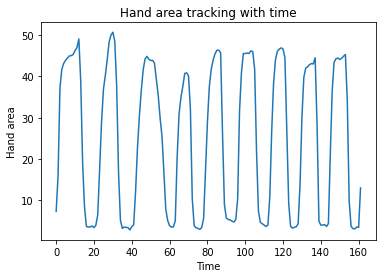

In [20]:
f_name = '2021-11-7-0-19-30-bare_hand_test_gzip.hkl'
# hand_reshow_by_video(f_name)

## function analysis by read file 

In [19]:
def hand_area_analysis(file_name):
# read data
    hand_area, time_r, result_r,image_width, image_height = hand_data_read_plot(file_name)
# remove noise
    c_r, c, b_r, b = hand_area_noise_rm(hand_area)
# show peak/valley speed per min
    speed = hand_area_pv_speed(c_r,b_r,time_r)
# plot remove noise progress
    hand_area_noise_rm_plot(hand_area, c_r, c, b_r, b)
# landmark group registration
    img, area, FRE = group_landmark_registion(result_r,c_r,b_r,image_height,image_width)
# plot group registration
    hand_area_landmarks_group_plot(img, area, FRE)
# plot area of peak and valley after registration
    hand_area_pv_plot(area)

In [22]:
# f_name = '2021-11-7-0-19-30-bare_hand_test_gzip.hkl'
# hand_area_analysis(f_name)

In [23]:
filename = "one_rb_band_green"
# data_s, fname = hand_area_tracking_recording(filename)

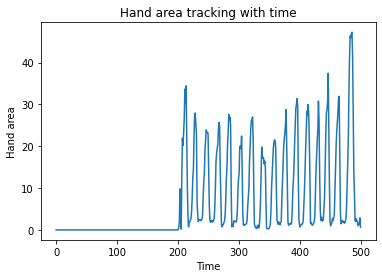

data save success on: 2021-11-7-1-17-5-two_rb_band_green_blue_gzip.hkl
total time: 36.29 s
file size: 0.64 MB


In [133]:
filename = "two_rb_band_green_blue"
# data_s, fname = hand_area_tracking_recording(filename)

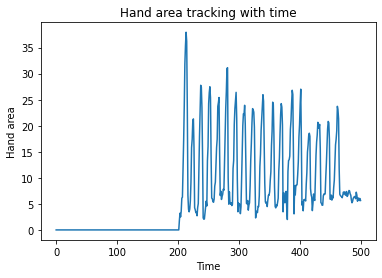

data save success on: 2021-11-8-16-47-23-three_rb_band_rgb_gzip.hkl
total time: 37.92 s
file size: 0.64 MB


In [102]:
filename = "three_rb_band_rgb"
data_s, fname = hand_area_tracking_recording(filename)

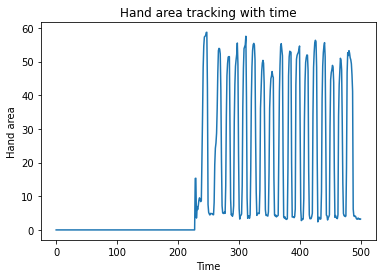

data save success on: 2021-11-8-16-49-20-bare_hand_gzip.hkl
total time: 33.62 s
file size: 0.59 MB


In [103]:
filename = "bare_hand"
data_s, fname = hand_area_tracking_recording(filename)

# four groups experiment independent compare

两组实验分别都以每组第一个手作为基准
- 第一组 一根橡皮筋
- 第二组 两根橡皮筋
- 第三组 三根像僻静
- 第四组 无橡皮筋

并且以第一组的peak和velley作为基准做landmark based registration

data read success of: 2021-11-7-1-14-50-one_rb_band_green_gzip.hkl
total time: 34.16 s
file size: 0.66 MB


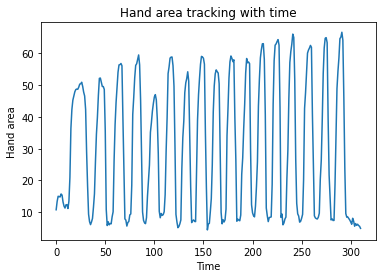

Real peak number:17 
original peak number:35
remove noise:18
Real valley number:17
original valley number:34
remove noise:17
hand area peak speed: 35.27 per min
hand area valley speed: 34.71 per min


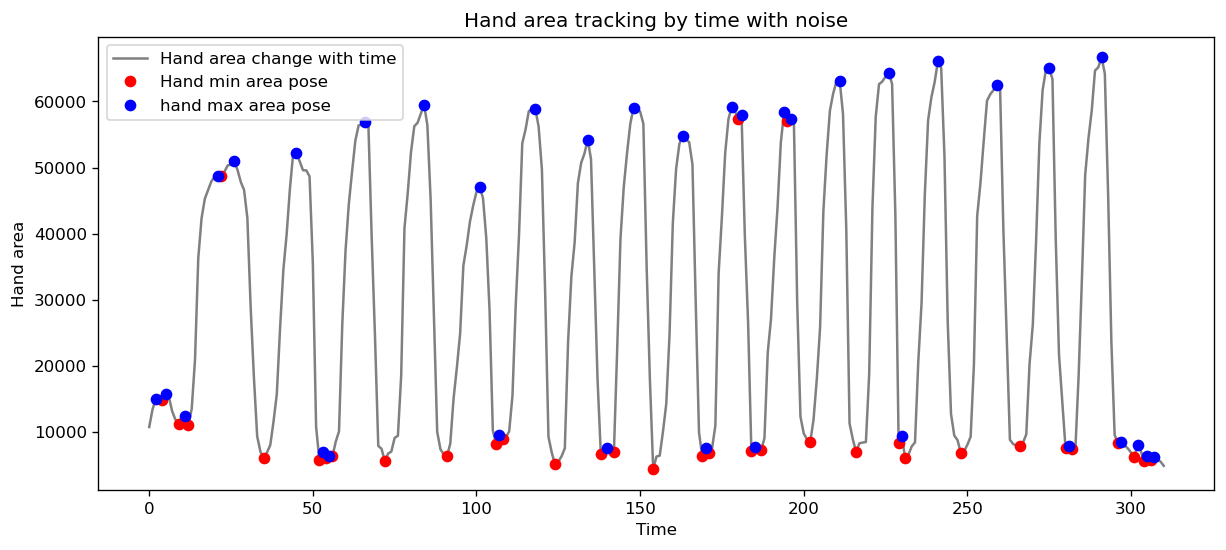

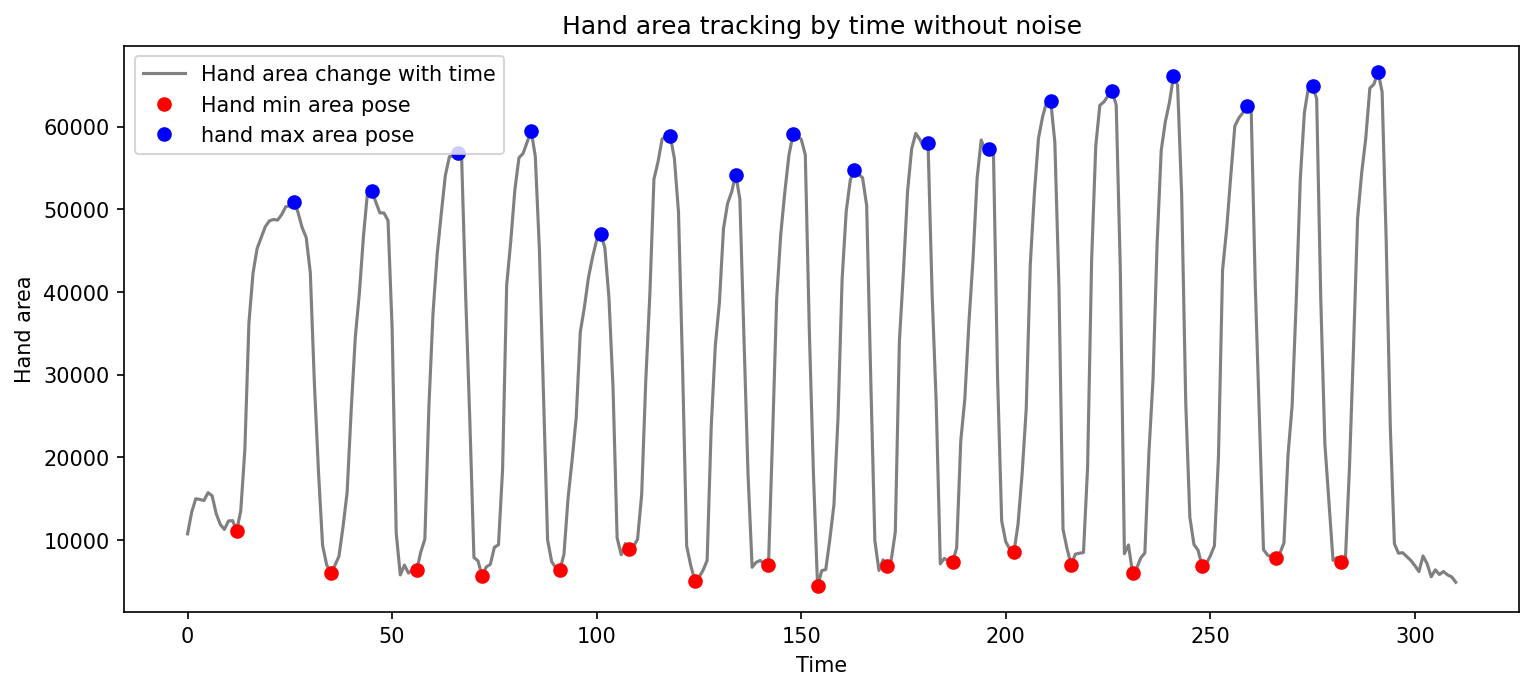

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


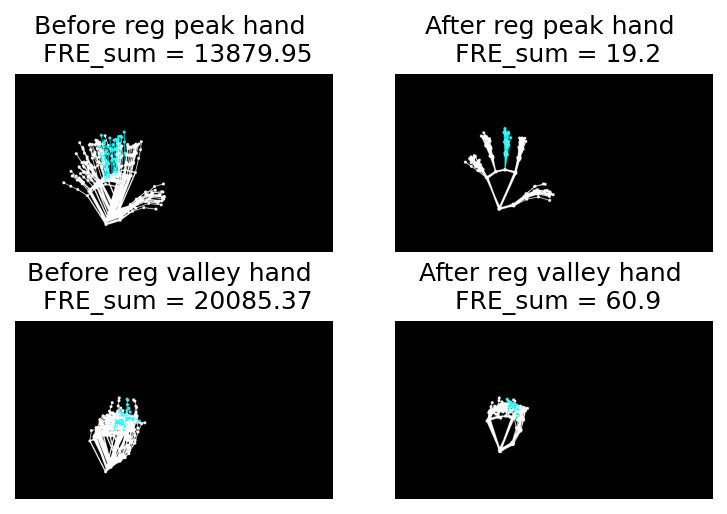

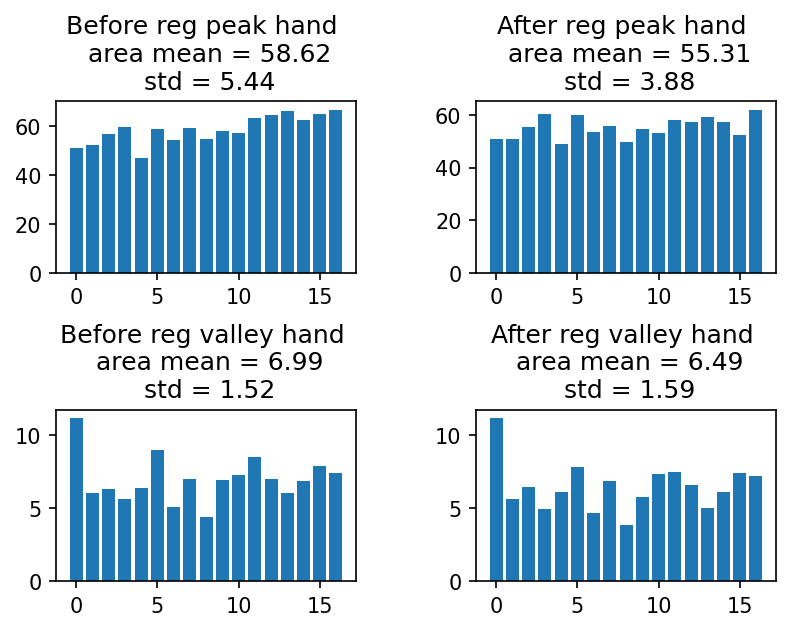

In [20]:
file_one_rb = '2021-11-7-1-14-50-one_rb_band_green_gzip.hkl'
file_two_rb = '2021-11-7-1-17-5-two_rb_band_green_blue_gzip.hkl'
file_three_rb = '2021-11-8-16-47-23-three_rb_band_rgb_gzip.hkl'
file_bare_hand = '2021-11-8-16-49-20-bare_hand_gzip.hkl'
hand_area_analysis(file_one_rb)


data read success of: 2021-11-7-1-17-5-two_rb_band_green_blue_gzip.hkl
total time: 33.86 s
file size: 0.64 MB


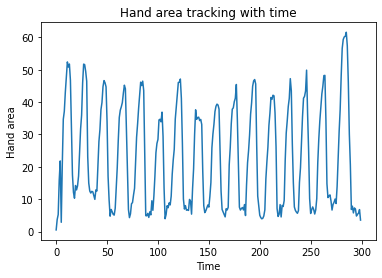

Real peak number:16 
original peak number:47
remove noise:31
Real valley number:15
original valley number:46
remove noise:31
hand area peak speed: 31.95 per min
hand area valley speed: 31.96 per min


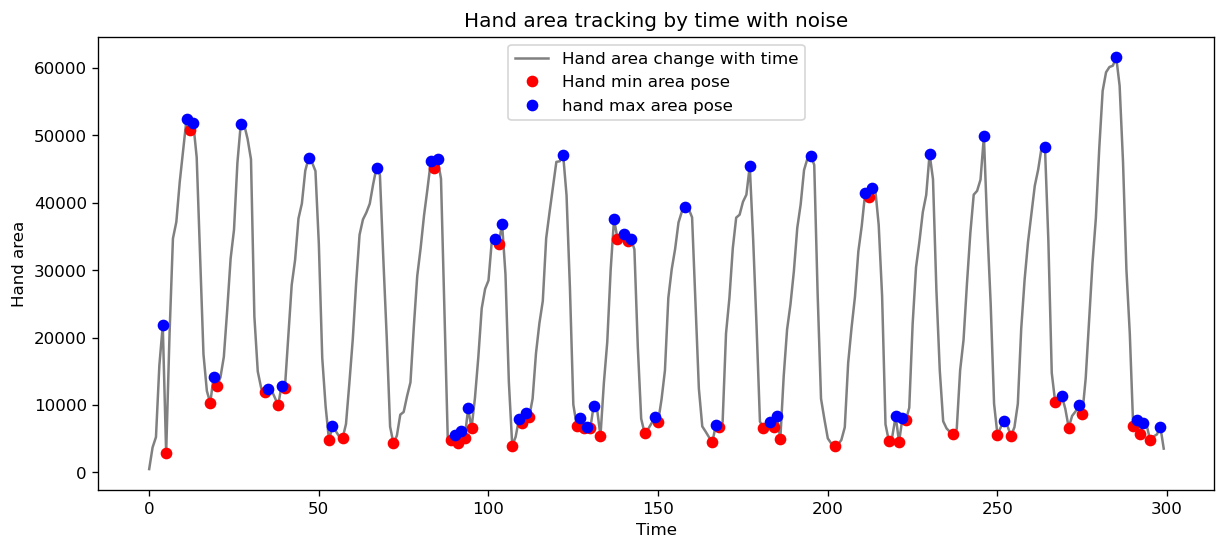

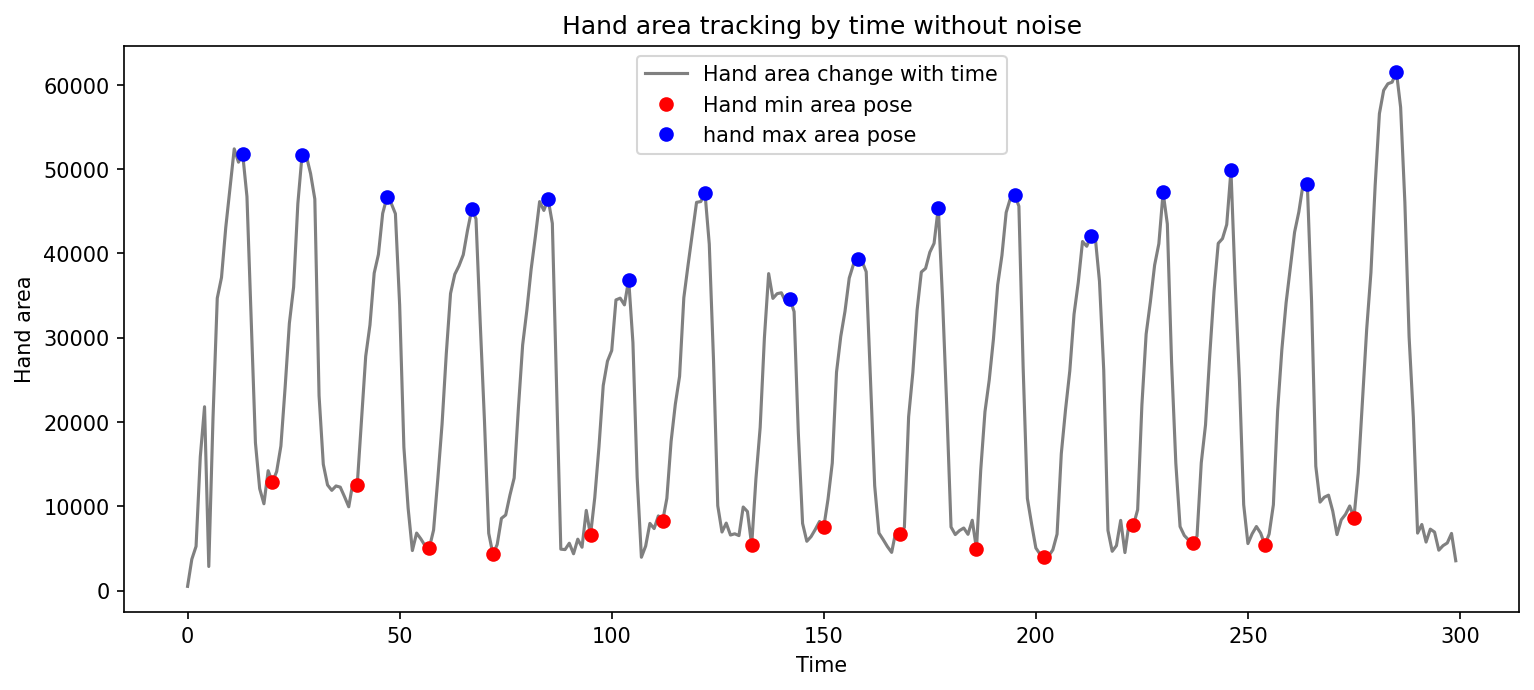

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


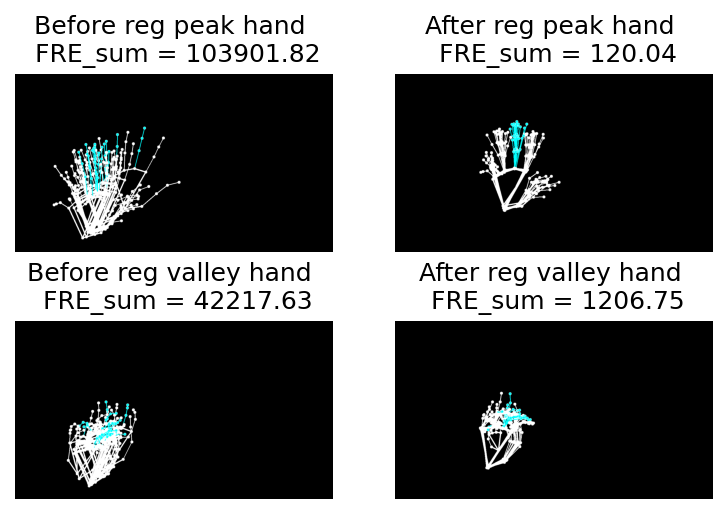

<ipython-input-17-e5cb7ca3ce90>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  area = np.array(area)


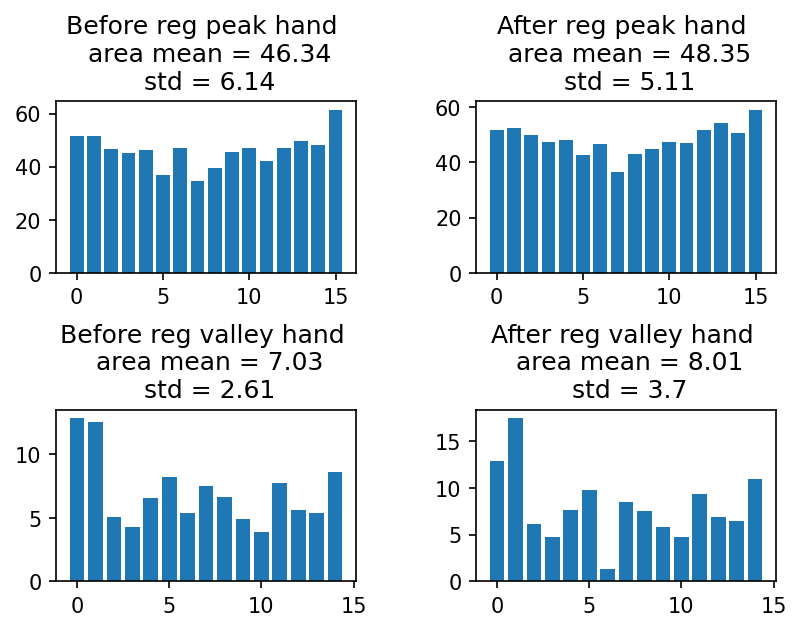

In [21]:
hand_area_analysis(file_two_rb)

data read success of: 2021-11-8-16-47-23-three_rb_band_rgb_gzip.hkl
total time: 35.58 s
file size: 0.64 MB


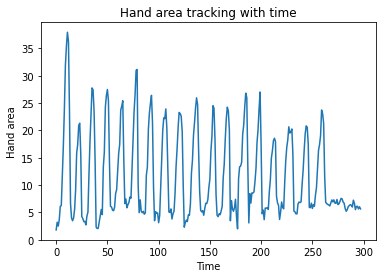

Real peak number:18 
original peak number:54
remove noise:36
Real valley number:15
original valley number:53
remove noise:38
hand area peak speed: 37.09 per min
hand area valley speed: 30.59 per min


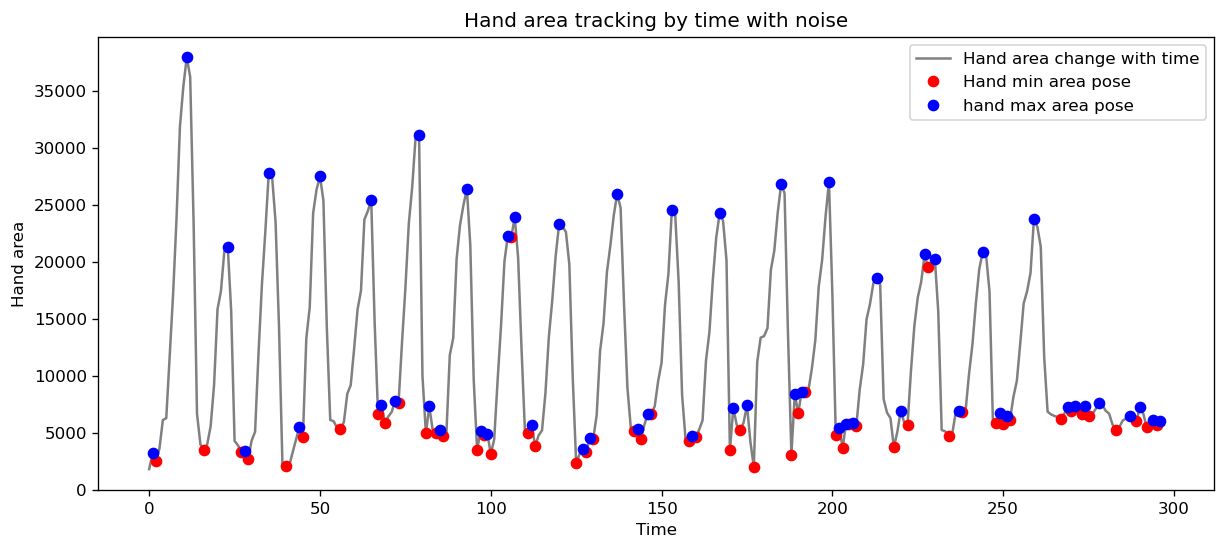

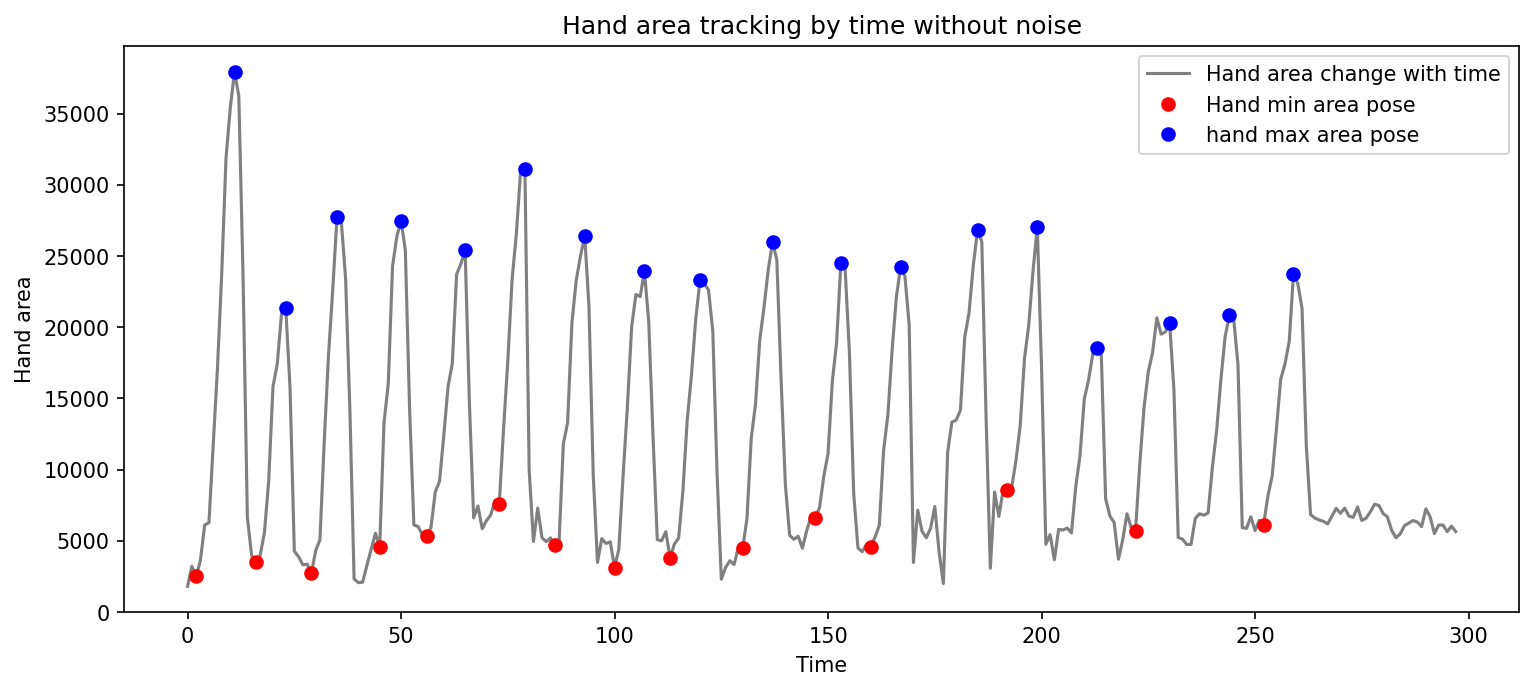

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


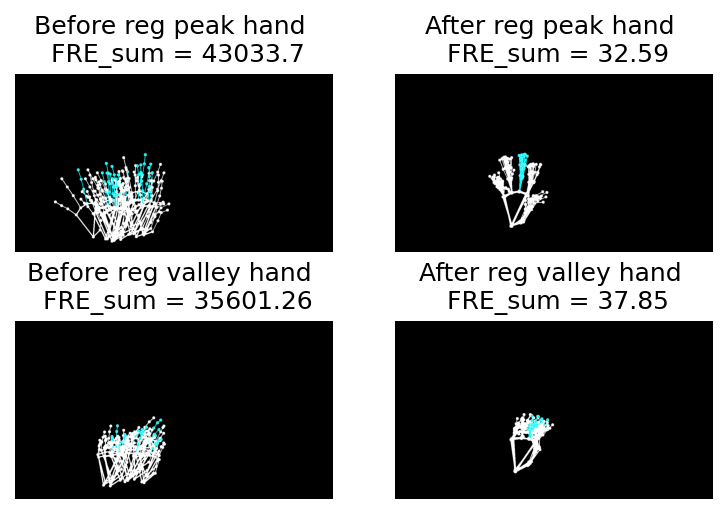

<ipython-input-17-e5cb7ca3ce90>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  area = np.array(area)


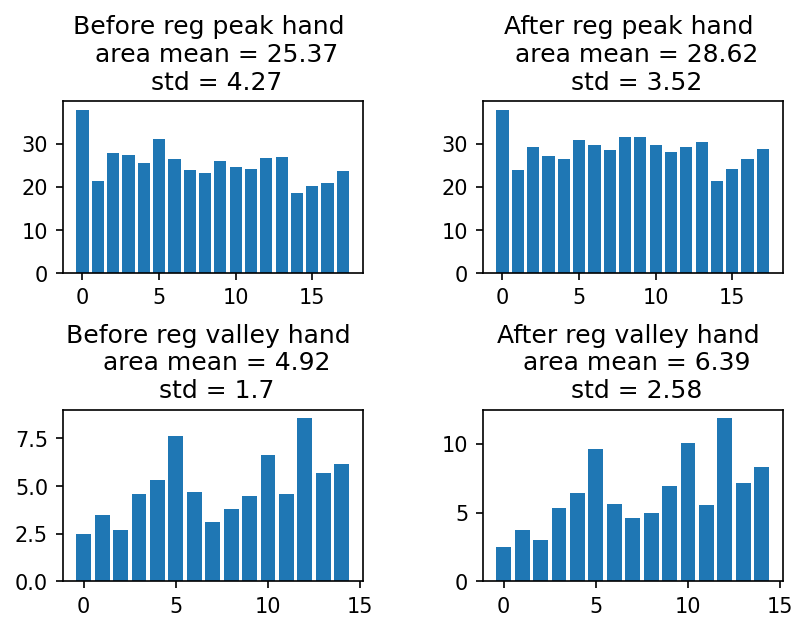

In [22]:
hand_area_analysis(file_three_rb)

data read success of: 2021-11-8-16-49-20-bare_hand_gzip.hkl
total time: 32.22 s
file size: 0.59 MB


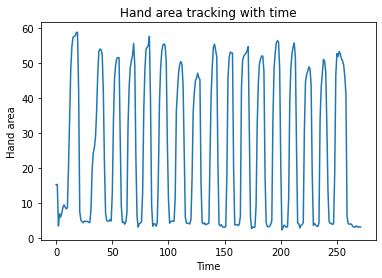

Real peak number:17 
original peak number:38
remove noise:21
Real valley number:17
original valley number:37
remove noise:20
hand area peak speed: 38.41 per min
hand area valley speed: 37.8 per min


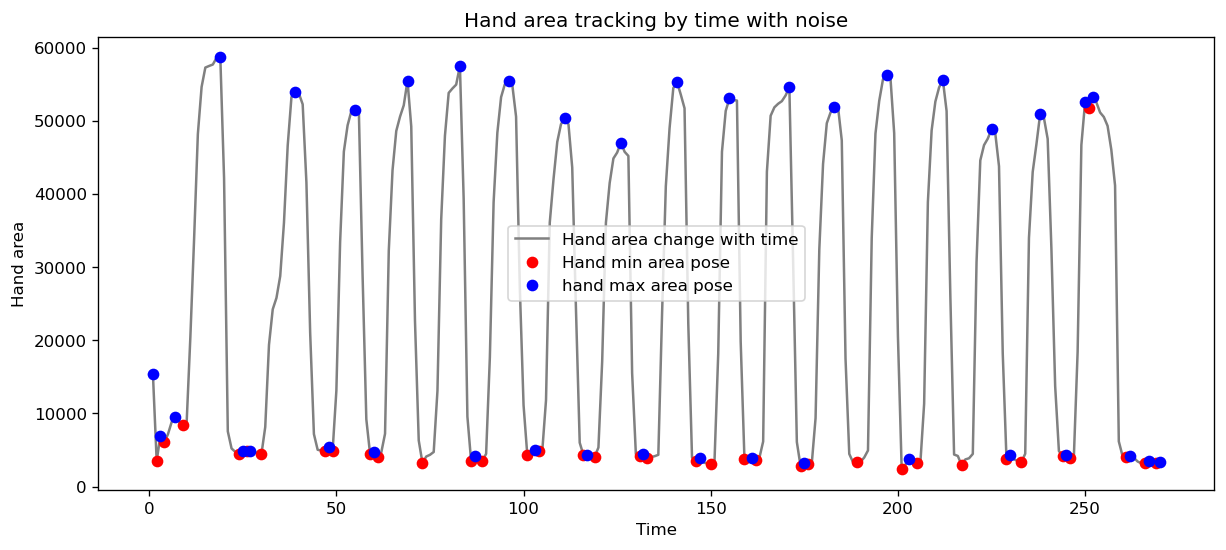

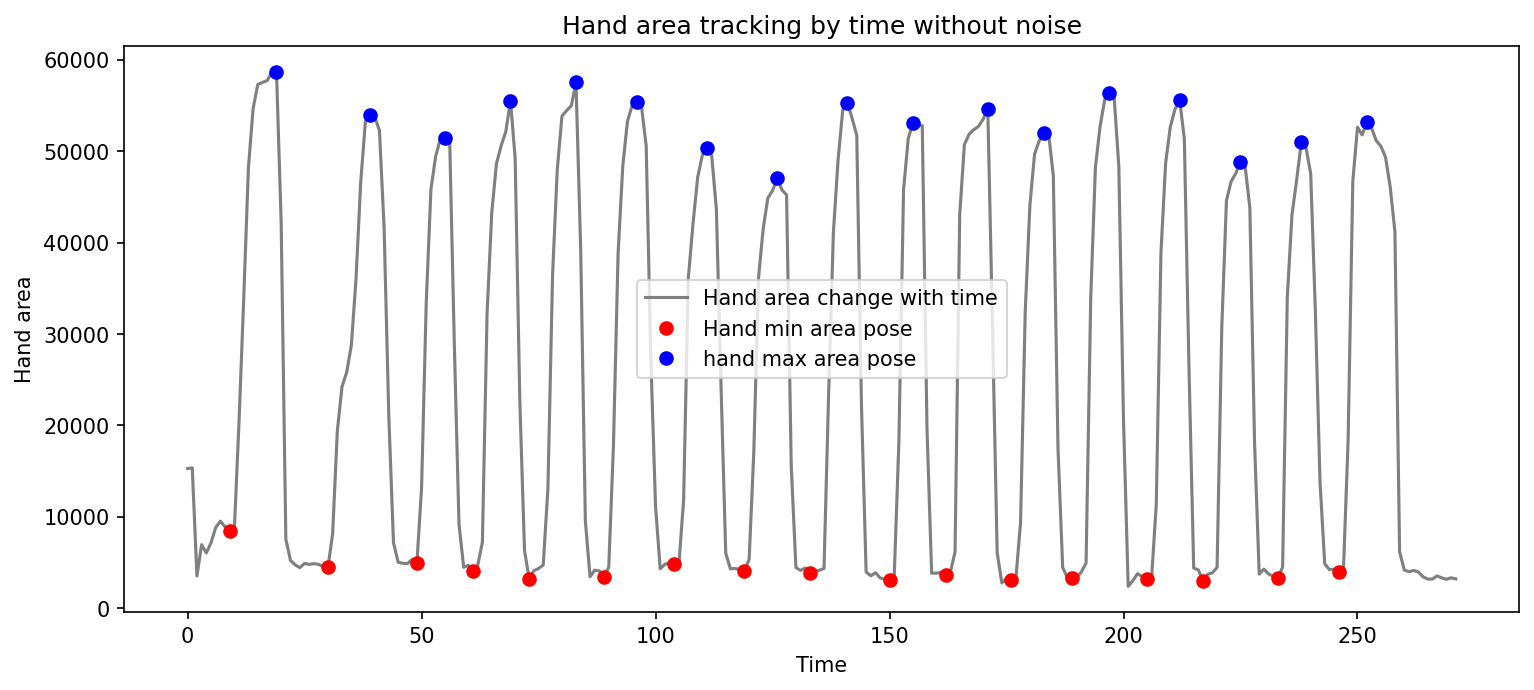

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


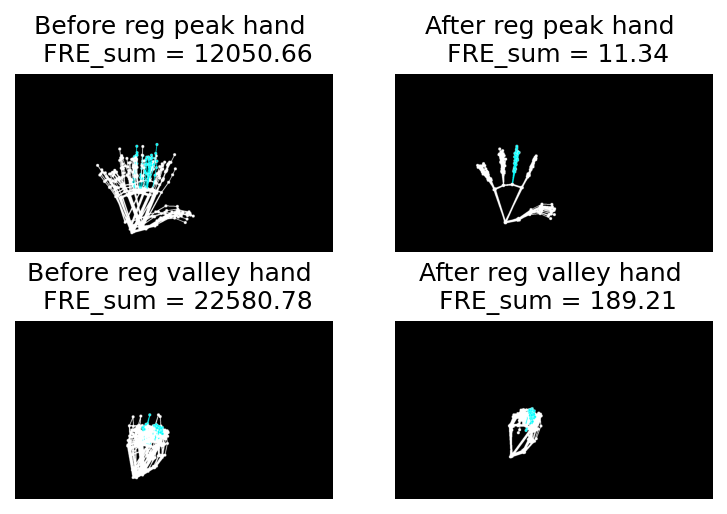

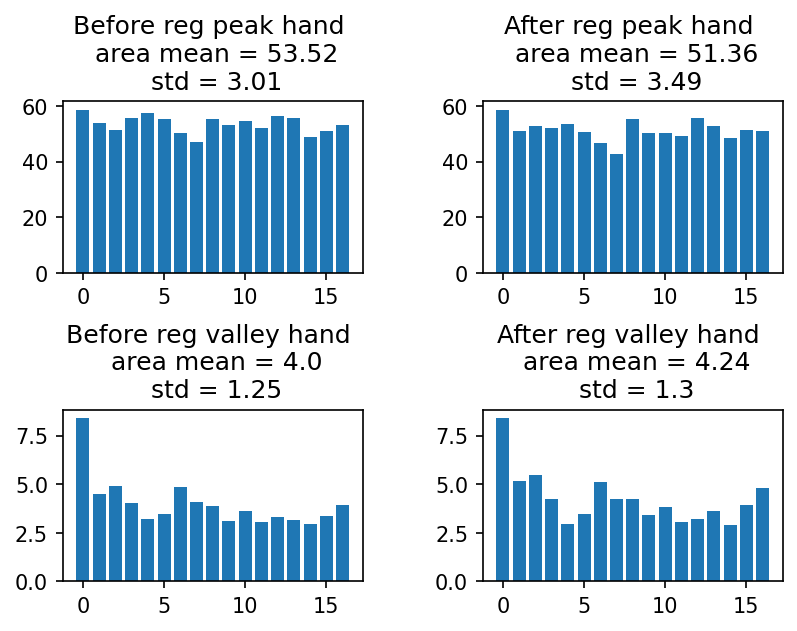

In [23]:
hand_area_analysis(file_bare_hand)

In [24]:
# cap = cv2.VideoCapture(0)
# cap.release()

# function four experiment compare

第二组实验 registrate to the first group first peak and valley

data read success of: 2021-11-8-16-47-23-three_rb_band_rgb_gzip.hkl
total time: 35.58 s
file size: 0.64 MB


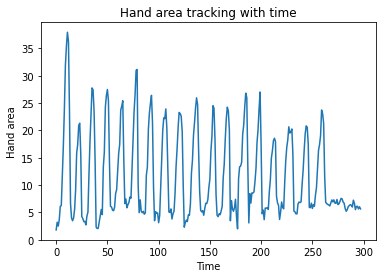

In [235]:
file_one_rb = '2021-11-7-1-14-50-one_rb_band_green_gzip.hkl'
file_two_rb = '2021-11-7-1-17-5-two_rb_band_green_blue_gzip.hkl'
file_three_rb = '2021-11-8-16-47-23-three_rb_band_rgb_gzip.hkl'
file_bare_hand = '2021-11-8-16-49-20-bare_hand_gzip.hkl'
# def hand_area_two_group_analysis(file_name1,file_name2):
file_name3 = file_one_rb
file_name4 = file_two_rb
file_name1 = file_three_rb
file_name2 = file_bare_hand
#     f2=>f1
# read data
hand_area1, time_r1, result_r1,image_width1, image_height1 = hand_data_read_plot(file_name1)


data read success of: 2021-11-8-16-49-20-bare_hand_gzip.hkl
total time: 32.22 s
file size: 0.59 MB


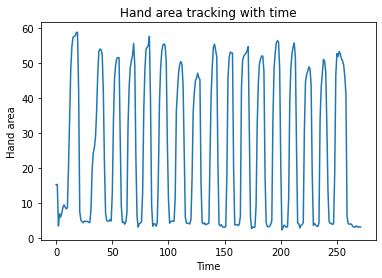

In [236]:
hand_area2, time_r2, result_r2,image_width2, image_height2 = hand_data_read_plot(file_name2)

data read success of: 2021-11-7-1-14-50-one_rb_band_green_gzip.hkl
total time: 34.16 s
file size: 0.66 MB


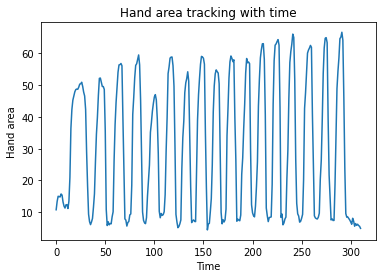

In [237]:
hand_area3, time_r3, result_r3,image_width3, image_height3 = hand_data_read_plot(file_name3)

data read success of: 2021-11-7-1-17-5-two_rb_band_green_blue_gzip.hkl
total time: 33.86 s
file size: 0.64 MB


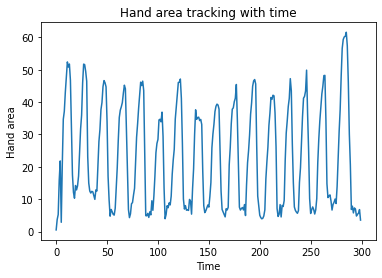

In [238]:
hand_area4, time_r4, result_r4,image_width4, image_height4 = hand_data_read_plot(file_name4)

## noise remove output

In [239]:
# remove noise
c_r1, c1, b_r1, b1 = hand_area_noise_rm(hand_area1)
speed1 = hand_area_pv_speed(c_r1,b_r1,time_r1)
print('\n')
c_r2, c2, b_r2, b2 = hand_area_noise_rm(hand_area2)
# show peak/valley speed per min
speed2 = hand_area_pv_speed(c_r2,b_r2,time_r2)

print('\n')
c_r3, c3, b_r3, b3 = hand_area_noise_rm(hand_area3)
# show peak/valley speed per min
speed3 = hand_area_pv_speed(c_r3,b_r3,time_r3)

print('\n')
c_r4, c4, b_r4, b4 = hand_area_noise_rm(hand_area4)
# show peak/valley speed per min
speed4 = hand_area_pv_speed(c_r4,b_r4,time_r4)


Real peak number:18 
original peak number:54
remove noise:36
Real valley number:15
original valley number:53
remove noise:38
hand area peak speed: 37.09 per min
hand area valley speed: 30.59 per min


Real peak number:17 
original peak number:38
remove noise:21
Real valley number:17
original valley number:37
remove noise:20
hand area peak speed: 38.41 per min
hand area valley speed: 37.8 per min


Real peak number:17 
original peak number:35
remove noise:18
Real valley number:17
original valley number:34
remove noise:17
hand area peak speed: 35.27 per min
hand area valley speed: 34.71 per min


Real peak number:16 
original peak number:47
remove noise:31
Real valley number:15
original valley number:46
remove noise:31
hand area peak speed: 31.95 per min
hand area valley speed: 31.96 per min


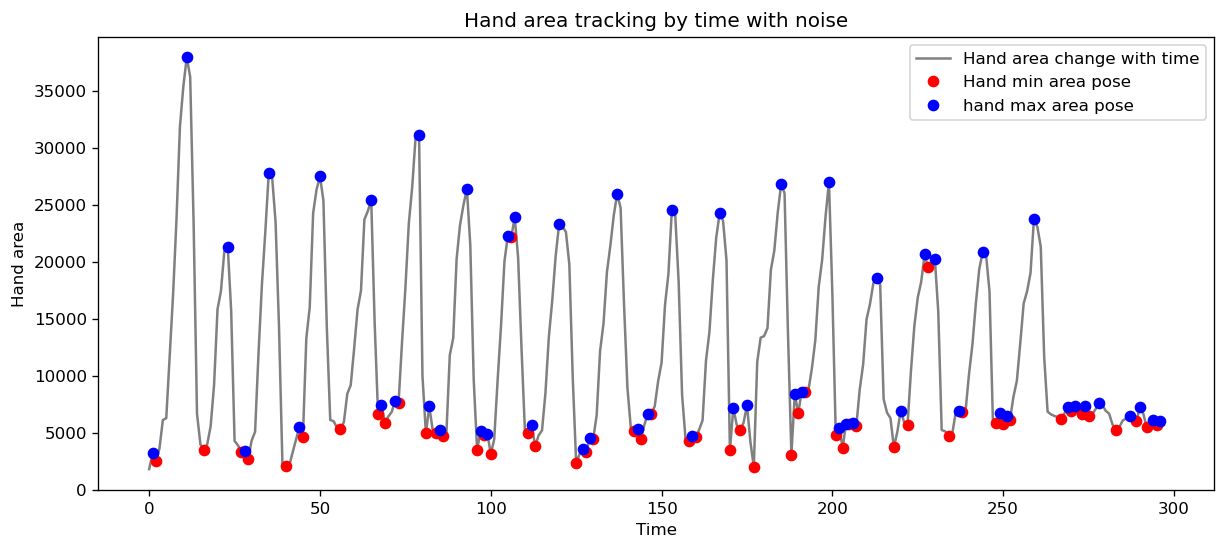

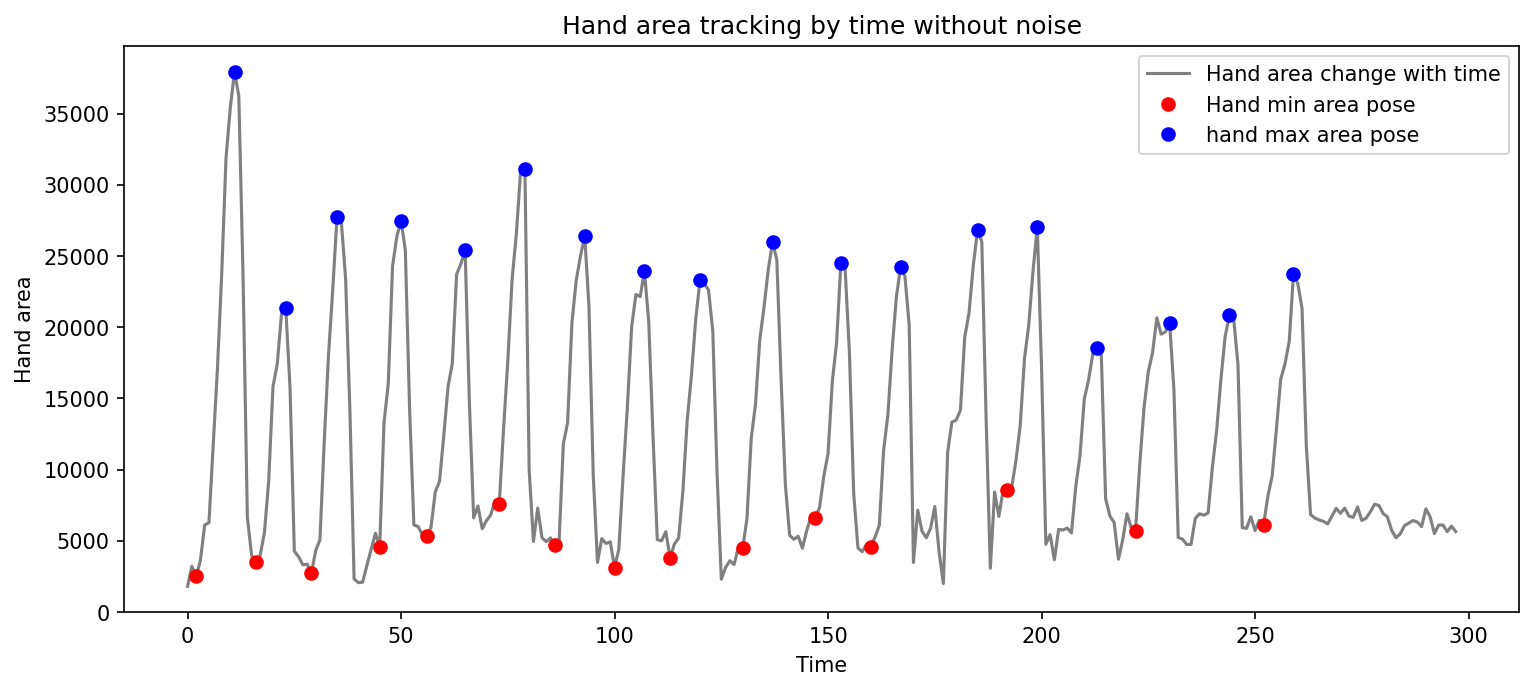

In [240]:
# plot remove noise progress
hand_area_noise_rm_plot(hand_area1, c_r1, c1, b_r1, b1)

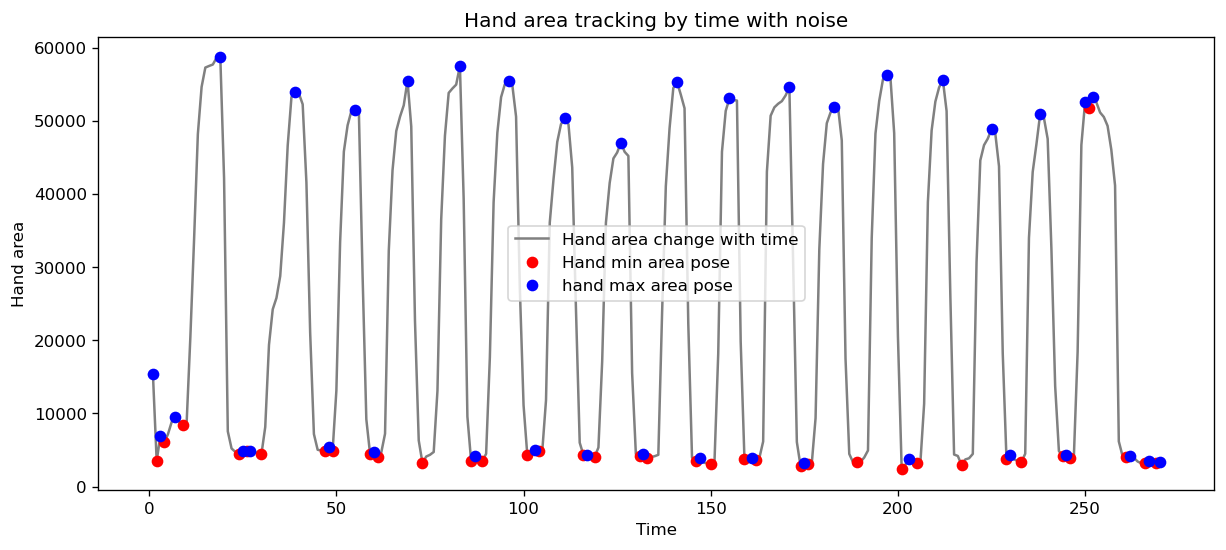

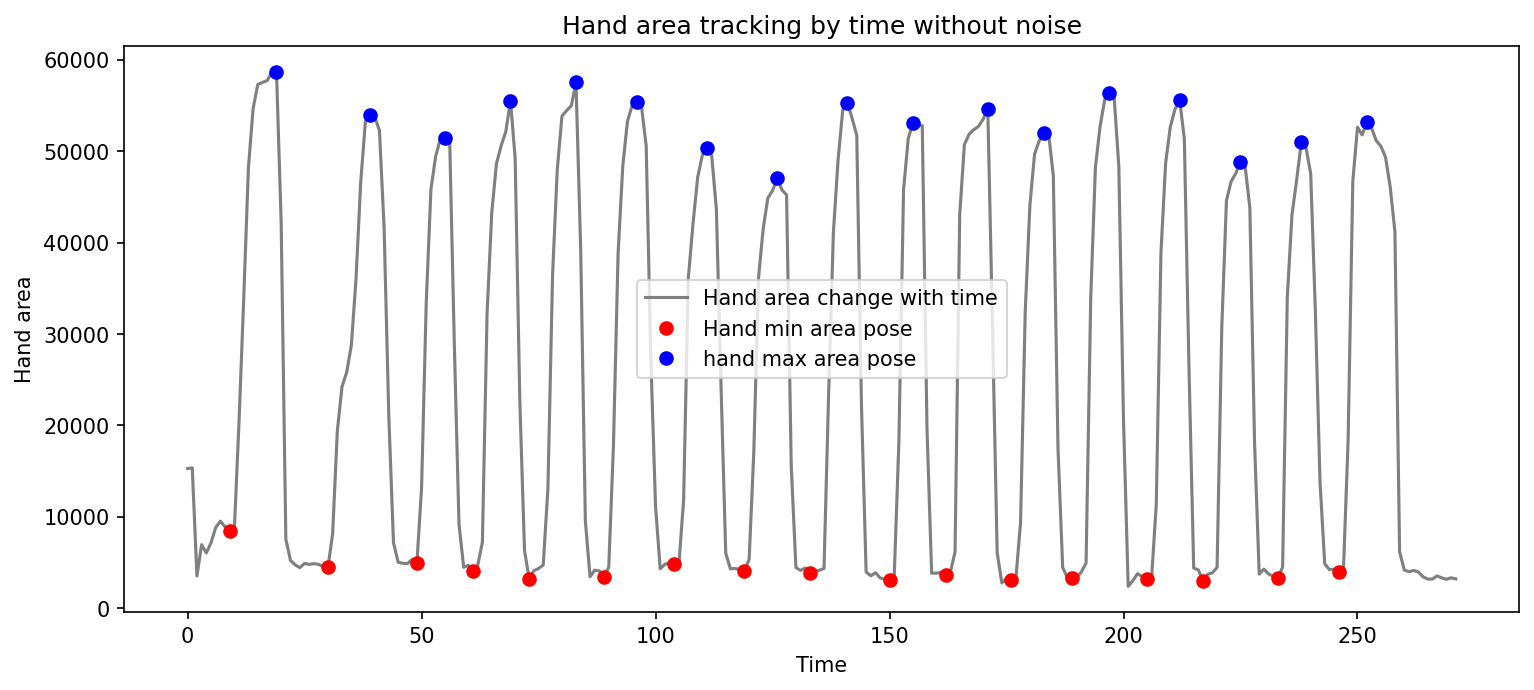

In [241]:
hand_area_noise_rm_plot(hand_area2, c_r2, c2, b_r2, b2)

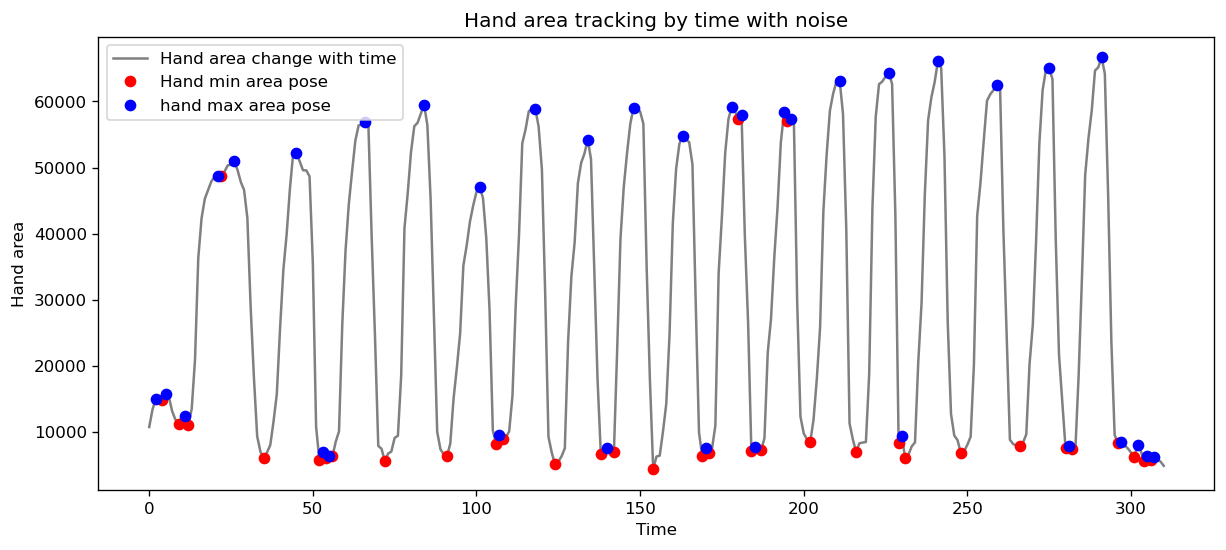

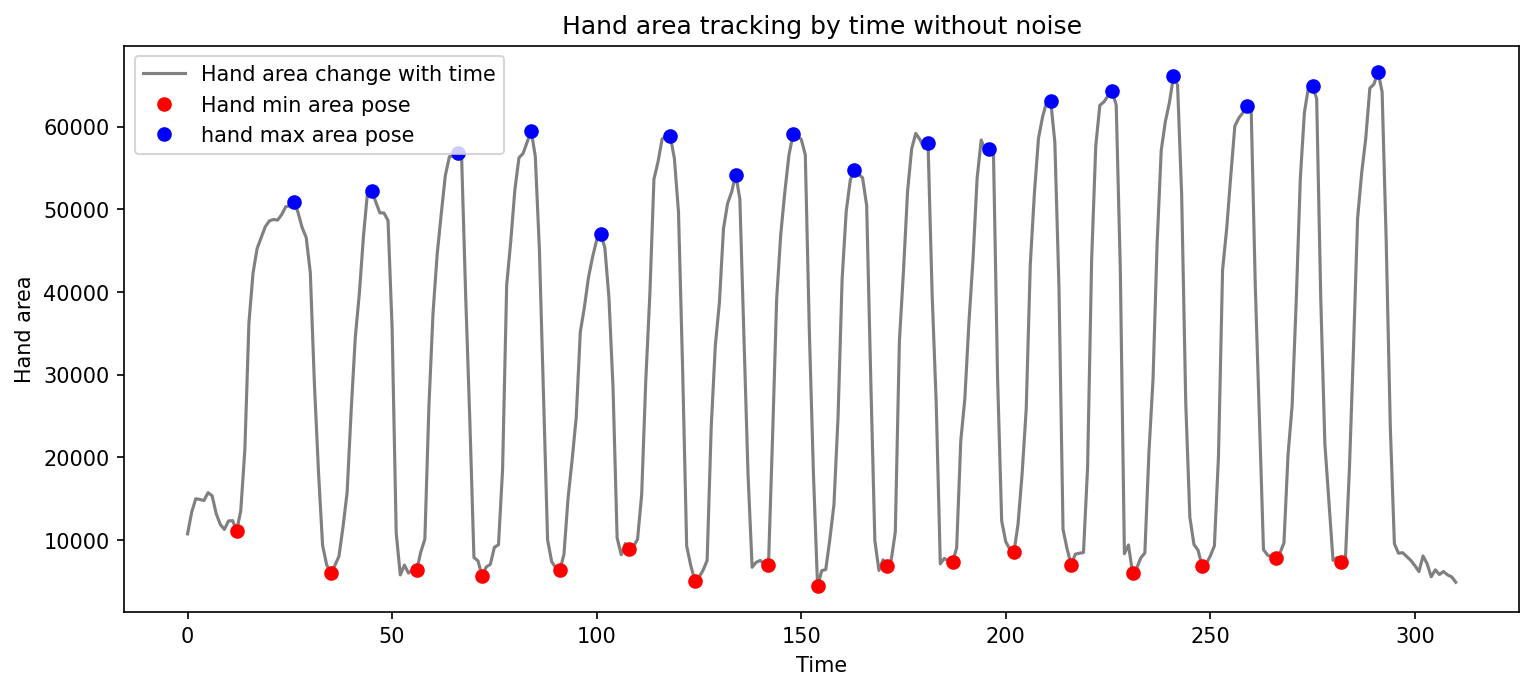

In [242]:
hand_area_noise_rm_plot(hand_area3, c_r3, c3, b_r3, b3)

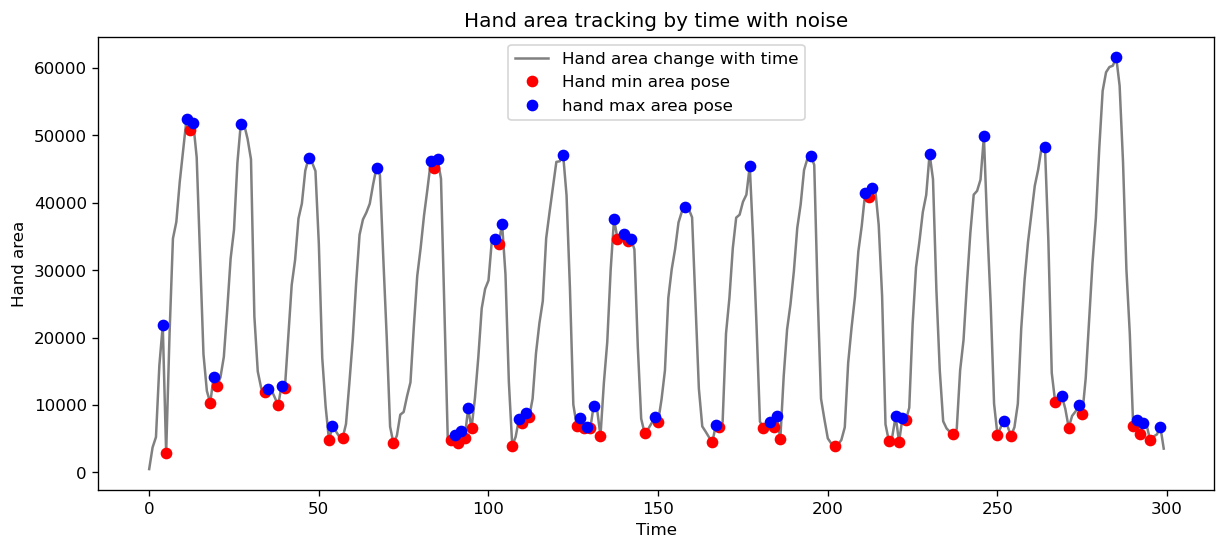

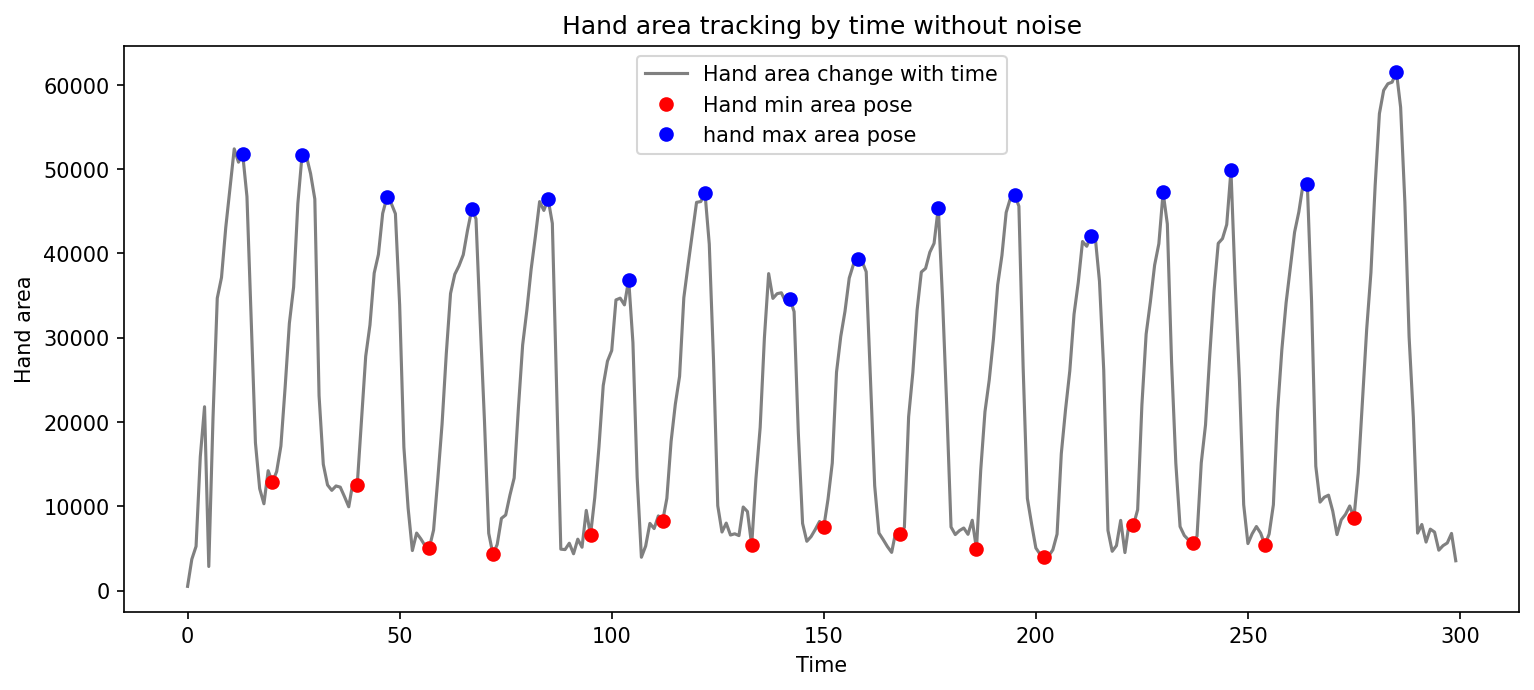

In [243]:
hand_area_noise_rm_plot(hand_area4, c_r4, c4, b_r4, b4)

after add two rubber band, the exercised speed decrease

## Group compare code

In [244]:


# landmark group registration
img1, area1, FRE1 = group_landmark_registion(result_r1,c_r1,b_r1,image_height1,image_width1)
img2, area2, FRE2 = two_group_landmark_registion(result_r2,c_r2,b_r2,result_r1,c_r1,b_r1,image_height2,image_width2)
img3, area3, FRE3 = two_group_landmark_registion(result_r3,c_r3,b_r3,result_r1,c_r1,b_r1,image_height2,image_width2)
img4, area4, FRE4 = two_group_landmark_registion(result_r4,c_r4,b_r4,result_r1,c_r1,b_r1,image_height2,image_width2)




## print result together

In [245]:
def area_analysis_print(area):
    kp = 1000
    area = np.array(area)
    area_p_b = np.array(area[0])/kp
    area_p_f = np.array(area[1])/kp
    area_v_b = np.array(area[2])/kp
    area_v_f = np.array(area[3])/kp
    
    m1 = np.round(np.mean(area_p_b),2)
    m2 = np.round(np.mean(area_p_f),2)
    m3 = np.round(np.mean(area_v_b),2)
    m4 = np.round(np.mean(area_v_f),2)
    
    std1 = np.round(np.std(area_p_b),2)
    std2 = np.round(np.std(area_p_f),2)
    std3 = np.round(np.std(area_v_b),2)
    std4 = np.round(np.std(area_v_f),2)

    m = [m1,m2,m3,m4]
    std = [std1,std2,std3,std4]
    return m, std


In [246]:
area_all = [area1,area2,area3,area4]
FRE_all = [FRE1,FRE2,FRE3,FRE4]
# print(np.size(area3))
# print(np.mean(np.array(area_all[2]),1))
# area_analysis_print(np.array(area3))
for i in range(4):
#     print(i)
    m,std = area_analysis_print(area_all[i])
    print("Group"+str(i+1)+":")
    print("Hand mean area:")
    print(m)
    print("hand area std:")
    print(std)
    print("hand ared FRE:")
    print(np.round(FRE_all[i],2))
    print("\n")
# print(np.mean(area1,1))
# print(FRE1)

Group1:
Hand mean area:
[25.37, 28.62, 4.92, 6.39]
hand area std:
[4.27, 3.52, 1.7, 2.58]
hand ared FRE:
[43033.7     32.59 35601.26    37.85]


Group2:
Hand mean area:
[53.52, 40.55, 4.0, 4.6]
hand area std:
[3.01, 2.75, 1.25, 1.37]
hand ared FRE:
[4459.24  128.4  3725.54   26.74]


Group3:
Hand mean area:
[58.62, 41.48, 6.99, 6.22]
hand area std:
[5.44, 2.89, 1.52, 1.51]
hand ared FRE:
[56633.55   134.5  77988.7     79.48]


Group4:
Hand mean area:
[46.34, 32.33, 7.03, 5.39]
hand area std:
[6.14, 3.33, 2.61, 2.5]
hand ared FRE:
[106501.17    146.95 146210.28    868.5 ]




<ipython-input-245-83f89953bcfd>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  area = np.array(area)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


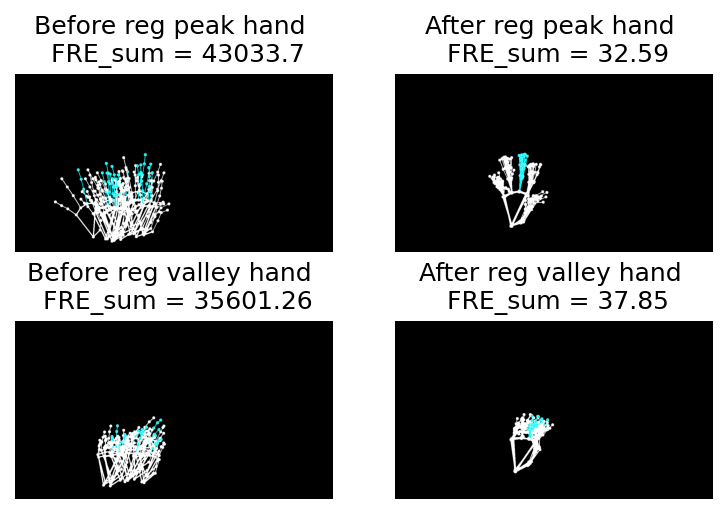

In [247]:
# plot group registration
hand_area_landmarks_group_plot(img1, area1, FRE1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


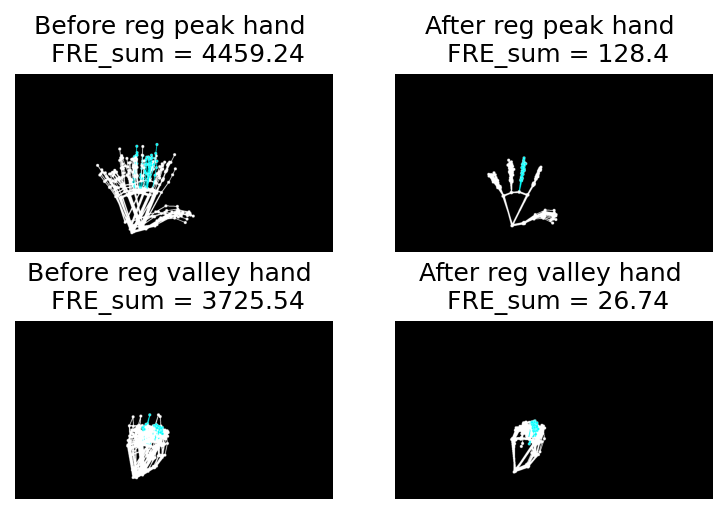

In [248]:
hand_area_landmarks_group_plot(img2, area2, FRE2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


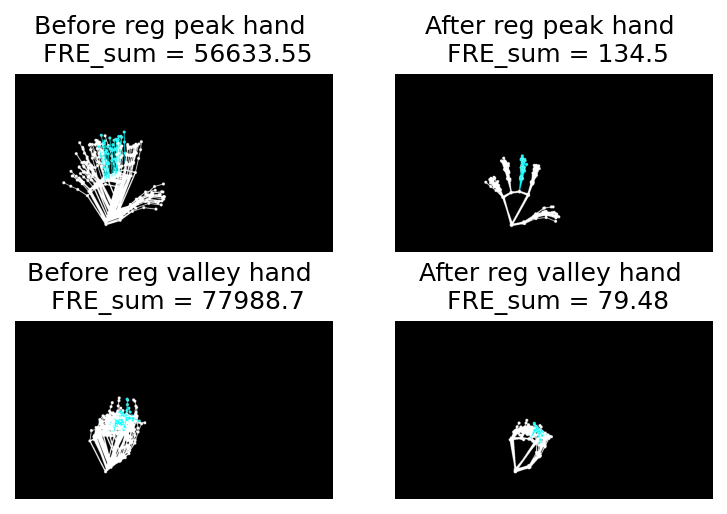

In [249]:
hand_area_landmarks_group_plot(img3, area3, FRE3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


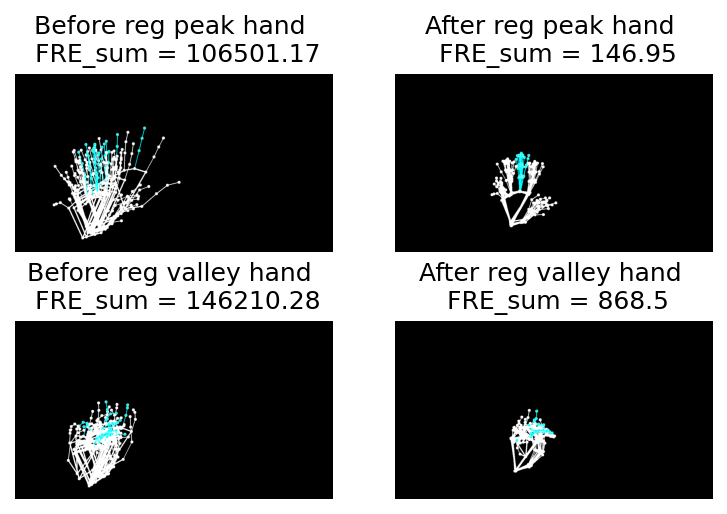

In [250]:
hand_area_landmarks_group_plot(img4, area4, FRE4)

<ipython-input-17-e5cb7ca3ce90>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  area = np.array(area)


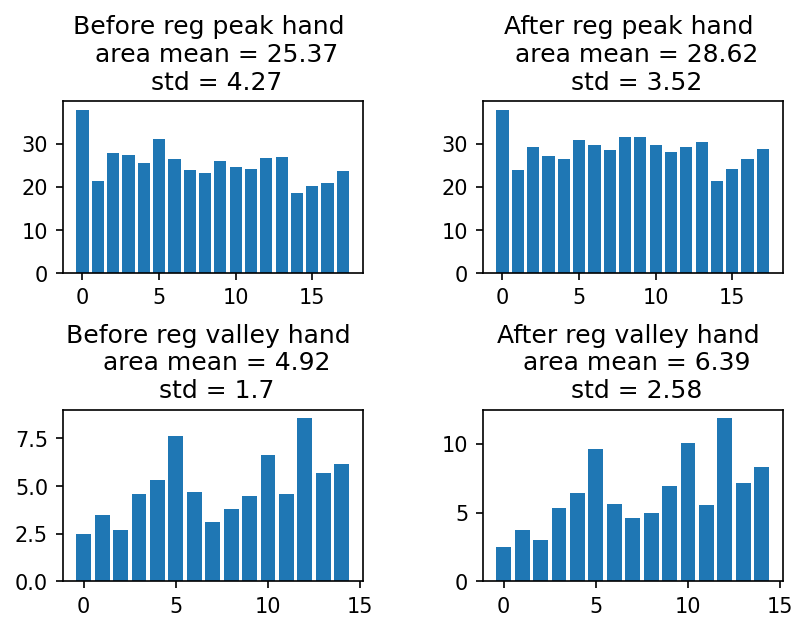

In [251]:

# plot area of peak and valley after registration
hand_area_pv_plot(area1)

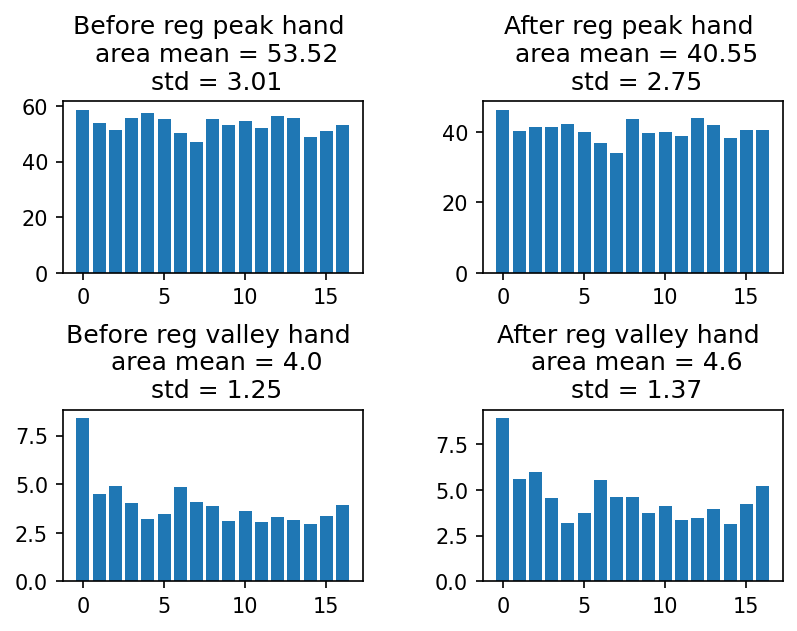

In [252]:
# plot area of peak and valley after registration
# print(len(area2[3]))
hand_area_pv_plot(area2)

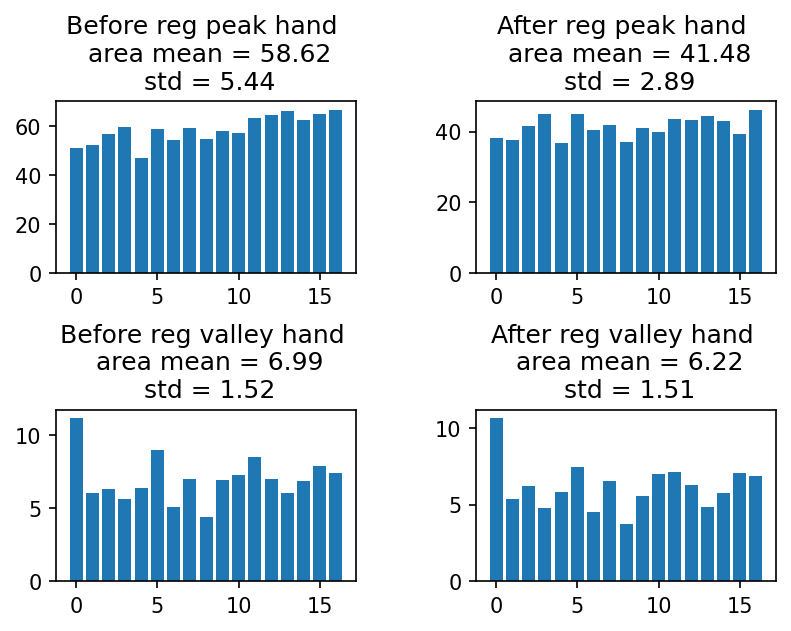

In [253]:
hand_area_pv_plot(area3)

<ipython-input-17-e5cb7ca3ce90>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  area = np.array(area)


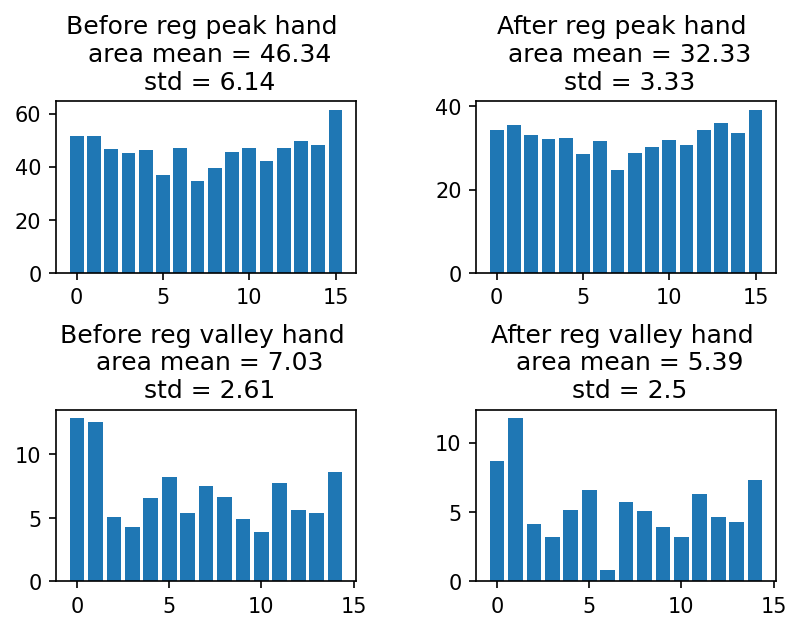

In [254]:
hand_area_pv_plot(area4)

## couclusion

通过直接匹配手的21个关节点,结论是面积变化有略微差距,符合预期,但面积变化不够明显. 

测试匹配手掌的五个点, index分别是 [0,5,9,13,17]. 结论:在一根,两根,三根橡皮筋的情况下, 无论以谁为模板, 都能正确判断出正确的结论. 无论以谁为基准, 光手都不是最大面积,基本和单橡皮筋一致,这个结果古怪,需要分析原因.

# experiment presentation

In [255]:
# filename = "presentation_test"
# data_s, fname = hand_area_tracking_recording(filename)

In [256]:
f_name = '2021-11-7-0-19-30-bare_hand_test_gzip.hkl'
# hand_reshow_by_video(f_name)

In [257]:
# hand_area_analysis(fname)
# img1, area1, FRE1 = group_landmark_registion(result_r1,c_r1,b_r1,image_height1,image_width1)
# img2, area2, FRE2 = two_group_landmark_registion(result_r2,c_r2,b_r2,result_r1,c_r1,b_r1,image_height2,image_width2)

# different people data analysis